In [ ]:
%%capture
!pip install simcse
!pip install wget

import simcse
import wget

filename = wget.download("http://huggingface.co/datasets/princeton-nlp/datasets-for-simcse/resolve/main/wiki1m_for_simcse.txt")

with open(filename, "r") as f: 
    
    text = [line.rstrip('\n') for line in f]
'''
filename2 = wget.download("https://huggingface.co/datasets/princeton-nlp/datasets-for-simcse/resolve/main/nli_for_simcse.csv")

with open(filename2, "r") as f:
    
    text2 = [line.rstrip('\n') for line in f]

'''

In [ ]:
import numpy as np
import pandas as pd
import random
import re
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
%%capture
!pip install transformers

In [ ]:
train = text[:int(0.75*len(text))]
valid = text[int(0.75*len(text)) + 1:int(0.95*len(text))]
test = text[int(0.95*len(text)+1):]

In [ ]:
from transformers import AutoTokenizer, AutoModel, BertForNextSentencePrediction
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
# Build PyTorch dataset class instance for clinical text
class WikiNLIDataset(torch.utils.data.Dataset):

  def __init__(self,text):
    self.text = text
  
  def __len__(self):
    return len(self.text)

  def __getitem__(self,index):

    inputs = tokenizer(text[index],
                    return_tensors='pt',
                    max_length = 512,
                    truncation = True,
                    padding = 'max_length')

    return inputs

In [ ]:
train_dataset = WikiNLIDataset(train)
valid_dataset = WikiNLIDataset(valid)
test_dataset = WikiNLIDataset(test)

In [ ]:
BATCH_SIZE = 3
trainloader = torch.utils.data.DataLoader(train_dataset,batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_dataset,batch_size = BATCH_SIZE, shuffle = True)
testloader = torch.utils.data.DataLoader(test_dataset,batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
X = next(iter(trainloader))

In [ ]:
# Build BERT Model + Linear Layer 
class SimCSE(nn.Module):

  def __init__(self):
    super().__init__()

    # Create models
    self.bert = AutoModel.from_pretrained("bert-base-uncased")
  
  def forward(self,input_ids,attention_mask,token_type_ids):

    # Pass through layers
    outputs = self.bert(input_ids.view(-1,512), attention_mask = attention_mask.view(-1,512),token_type_ids = token_type_ids.view(-1,512))
    outputs_cls = outputs['last_hidden_state'][:,0,:]

    outputs = outputs['pooler_output']
    return outputs,outputs_cls

In [ ]:
model = SimCSE()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [ ]:
class contrast_loss(torch.nn.Module):

    model.train()

    def __init__(self):
      super().__init__()

    def forward(self,batch,model,temp = 0.05):

      length = batch['input_ids'].shape[0]
      losses = []

      for i in range(length):

  
 
        # embedding with different dropout masks
        embedding_i = model(batch['input_ids'][i],batch['attention_mask'][i],batch['token_type_ids'][i])[0]
        embedding_ii = model(batch['input_ids'][i],batch['attention_mask'][i],batch['token_type_ids'][i])[0]

        numerator = torch.exp((nn.CosineSimilarity(dim = -1)(embedding_i,embedding_ii))/temp)
        denominator = 0

        for j in range(length):

          if (j!=i):

            denominator += torch.exp((nn.CosineSimilarity(dim = -1)(embedding_i,model(batch['input_ids'][j],batch['attention_mask'][j],batch['token_type_ids'][j])[0]))/temp)
        
        losses.append(-torch.log(numerator/denominator))

      return torch.mean(torch.stack(losses))

In [ ]:
class contrastive_loss(torch.nn.Module):

  def __init__(self):
    super().__init__()

  def forward(self,batch,model,temp = 0.05):

    length = batch['input_ids'].shape[0]
    model.train()

    outs = model(batch['input_ids'],batch['attention_mask'],batch['token_type_ids'])[0]
    dot = outs@outs.T
    norms = torch.sqrt(torch.sum(outs**2,axis = 1)).unsqueeze(dim = 1)
    norms = norms@norms.T

    # A,B
    cos_ab = torch.div(dot,norms)

    # A,A
    out2 = model(batch['input_ids'],batch['attention_mask'],batch['token_type_ids'])[0]
    x = torch.sum(outs*out2,dim = 1).unsqueeze(dim = 1)
    norm1 = torch.sqrt(torch.sum(outs**2,axis = 1)).unsqueeze(dim = 1)
    norm2 = torch.sqrt(torch.sum(out2**2,axis = 1)).unsqueeze(dim = 1)
    cos_aa = torch.div(x,norm1*norm2)

    cos_ab[np.arange(length),np.arange(length)] = cos_aa.squeeze()
    cos_ab = torch.exp(cos_ab/temp)

    return torch.mean(-torch.log(torch.divide(torch.diag(cos_ab),(torch.sum(cos_ab,dim = 1)-torch.diag(cos_ab)))).unsqueeze(dim = 1))

In [ ]:
loss = contrastive_loss()

In [ ]:
from transformers import AdamW
optim = AdamW(model.parameters(), lr = 3e-5)

In [ ]:
!git clone https://github.com/princeton-nlp/SimCSE.git

Cloning into 'SimCSE'...
remote: Enumerating objects: 376, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 376 (delta 47), reused 31 (delta 30), pack-reused 287
Receiving objects: 100% (376/376), 28.29 MiB | 10.56 MiB/s, done.
Resolving deltas: 100% (190/190), done.


In [ ]:
!bash /content/SimCSE/SentEval/data/downstream/download_dataset.sh

--2021-10-13 03:31:43--  https://huggingface.co/datasets/princeton-nlp/datasets-for-simcse/resolve/main/senteval.tar
Resolving huggingface.co (huggingface.co)... 34.200.164.230, 3.213.134.133, 107.23.77.87, ...
Connecting to huggingface.co (huggingface.co)|34.200.164.230|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/datasets/princeton-nlp/datasets-for-simcse/bc43c148f7be97471c78fc4255399d3158cb99dfe8f2221999c918338b138c38 [following]
--2021-10-13 03:31:43--  https://cdn-lfs.huggingface.co/datasets/princeton-nlp/datasets-for-simcse/bc43c148f7be97471c78fc4255399d3158cb99dfe8f2221999c918338b138c38
Resolving cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)... 52.222.174.3, 52.222.174.26, 52.222.174.30, ...
Connecting to cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)|52.222.174.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89825280 (86M) [application/octet-stream]
Saving to: ‘senteval.tar’

senteva

In [ ]:
def build_text(dataset):
  with open(f'./STS/STSBenchmark/sts-{dataset}.csv') as file:
      content = file.readlines()
  text = [line.strip().split('\t')[-3:] for line in content]
  return text

In [ ]:
train = build_text('train')
test = build_text('test')
dev = build_text('dev')

In [ ]:
import pickle
with open("dev.txt", "rb") as fp:   # Unpickling
  b = pickle.load(fp)

FileNotFoundError: ignored

In [ ]:
MyFile=open('dev2.txt','w')

for element in dev:
    print(element)
    MyFile.write(str(element))
    MyFile.write('\n')
MyFile.close()

In [ ]:
# Build PyTorch dataset class instance for clinical text
class STSDataset(torch.utils.data.Dataset):

  def __init__(self,text):
    self.text = text
  
  def __len__(self):
    return len(self.text)

  def __getitem__(self,index):

    score = self.text[index][0]

    s1 = self.text[index][1]
    s2 = self.text[index][2]

    s1_inputs = tokenizer(s1,
                    return_tensors='pt',
                    max_length = 512,
                    truncation = True,
                    padding = 'max_length')
    
    s2_inputs = tokenizer(s2,
                    return_tensors='pt',
                    max_length = 512,
                    truncation = True,
                    padding = 'max_length')

    return score,s1_inputs,s2_inputs

In [ ]:
device = torch.device("cuda")

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
def compute_accuracy(model):

  model.to(device)
  model.eval()

  with torch.no_grad():

    labels = []
    predicted = []

    for index in range(len(dev)):

      if index<10:

        t = dev[index]
        score = float(t[0])
        s1_inputs = tokenizer(t[1],
                          return_tensors='pt',
                          max_length = 512,
                          truncation = True,
                          padding = 'max_length')
        s2_inputs = tokenizer(t[2],
                          return_tensors='pt',
                          max_length = 512,
                          truncation = True,
                          padding = 'max_length')
        
        e1 = model(s1_inputs['input_ids'].to(device),s1_inputs['attention_mask'].to(device),s1_inputs['token_type_ids'].to(device))[1]
        e2 = model(s2_inputs['input_ids'].to(device),s2_inputs['attention_mask'].to(device),s2_inputs['token_type_ids'].to(device))[1]

        labels.append(score)
        predicted.append(nn.CosineSimilarity()(e1,e2).item())

    print(labels)
    print(predicted)

    plt.scatter(labels,predicted)

    return np.corrcoef(labels,predicted)[0][1]

[5.0, 4.75, 5.0, 2.4, 2.75, 2.615, 5.0, 2.333, 3.75, 5.0]
[0.9960681200027466, 0.9387223124504089, 0.8760891556739807, 0.9895521402359009, 0.9886741638183594, 0.9758277535438538, 0.928398072719574, 0.9650601148605347, 0.9772124886512756, 0.9263986945152283]


-0.606441037151867

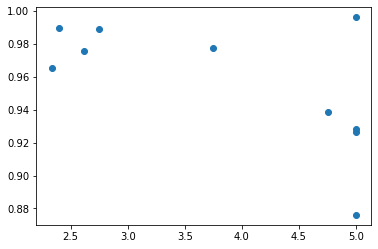

In [ ]:
compute_accuracy(model)

In [ ]:
t = dev[index]

In [ ]:
compute_accuracy(model)

In [ ]:
start_time = time.time()
NUM_EPOCHS = 1

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, batch in enumerate(trainloader):
        
      optim.zero_grad()

      loss = contrastive_loss(batch,model)
      loss.backward()

      if not batch_idx % 50:

        print(f"epoch number = {epoch}", f"batch {batch_idx}/{len(trainloader)}", f"loss = {round(loss.item(),2)}")

      optim.step()
            
    model.eval()
    
    if not batch_idx % 250:

      with torch.no_grad():

        print("Accuracy",compute_accuracy(model))

In [ ]:
start_time = time.time()
NUM_EPOCHS = 2

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, batch in enumerate(trainloader):
        
      optim.zero_grad()

      loss = contrastive_loss(batch,model)
      loss.backward()

      if not batch_idx % 50:

        print(f"epoch number = {epoch}", f"batch {batch_idx}/{len(trainloader)}", f"loss = {round(loss.item(),2)}")

      optim.step()
            
    model.eval()

    with torch.set_grad_enabled(False):
        print(f'training accuracy: '
              f'{compute_accuracy(model, trainloader, device):.2f}%'
              f'\nvalid accuracy: '
              f'{compute_accuracy(model, validloader, device):.2f}%')
        
    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {compute_accuracy(model, testloader, device):.2f}%')